# [NML-24] Assignment 2: Graph Neural Networks

TAs: [William Cappelletti](https://people.epfl.ch/william.cappelletti) and [Abdellah Rahmani](https://people.epfl.ch/abdellah.rahmani)

## Students

* Team: 5
* Students: Hans Kristian Bjorgo Kvaerum (381875), Kaede Johnson (357472)

## Instructions

**!! Read carefully before starting !!**

**Deadline:** April 30

**Grading:**
* The integrality of Assignment 2 will be scaled to 100% and will amount to 1/3 of the overall assignments score.
* The total number of points is **100**, the points for each exercise are stated in the instructions.
* All team members will receive the same grade based on the team solution.
* Collaboration between team members is encouraged. No collaboration between teams is allowed.

**Expected output:**

You will have coding and theoretical questions. Coding exercises shall be solved within the specified space:
```python
# Your solution here ###########################################################
...
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
```
Sometimes we provide variable names, such as `x = ...`; do not change names and stick to hinted typing, as they will be reused later.
Within the solution space, you can declare any other variable or function that you might need, but anything outside these lines shall not be changed, or it will invalidate your answers.

Theoretical questions shall be answered in the following markdown cell. The first line will be
```markdown
**Your answer here:**
...
```

**Solutions:**
* Your submission is self-contained in the `.ipynb` file.

* Code has to be clean and readable. Provide meaningful variable names and comment where needed.

* Textual answers in [markdown cells][md_cells] shall be short: one to two
  sentences. Math shall be written in [LaTeX][md_latex].
    **NOTE**: handwritten notes pasted in the notebook are ignored.

* You cannot import any other library than we imported, unless explicitly stated.

* Make sure all cells are executed before submitting. I.e., if you open the notebook again it should show numerical results and plots. Cells not run are ignored.

* Execute your notebook from a blank state before submission, to make sure it is reproducible. You can click "Kernel" then "Restart Kernel and Run All Cells" in Jupyter. We might re-run cells to ensure that the code is working and corresponds to the results.

[md_cells]: https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Working%20With%20Markdown%20Cells.html
[md_latex]: https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Working%20With%20Markdown%20Cells.html#LaTex-equations

## Objective

This assignment focuses on Graph Neural Networks. In the first part, you will load and prepare data using the PyTorch Geometric library. Next, you will define a GNN used to solve a task. You will train and test the Neural Network and comment on the results.
In the second part, you will define a new GNN block, in order to include it in the previous architecture.
The third part is theoretical and study a way to include structural properties in learned networks.

## Prerequisites

The additional [tutorial notebook](nml24_gnn_tutorial.ipynb) provides a broad overview of PyTorch and PyTorch Geometric, showing how to manipulate tensors and train neural networks and GNNs.

The following resources might help you familiarize with PyTorch and PyTorch geometric.

* [PyTorch: Learn the Basics](https://pytorch.org/tutorials/beginner/basics/intro.html)
* [PyTorch geometric: Official tutorials](https://pytorch-geometric.readthedocs.io/en/latest/get_started/colabs.html#official-examples)


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import os
# TODO: Fill in the `ROOT_PATH` with where you download the Assignment folder
ROOT_PATH = "/content/drive/MyDrive/network_ml/assignment2"  # Replace with your directory to A2 folder
print(os.listdir(ROOT_PATH)) # Check the content of the path
os.chdir(ROOT_PATH) # cd into directory
print(os.listdir(".")) # Check the content of current folder

['graph_learning_module.png', 'nml24_gnn_tutorial.ipynb', 'raw', 'processed', 'nml24_assignment2.ipynb']
['graph_learning_module.png', 'nml24_gnn_tutorial.ipynb', 'raw', 'processed', 'nml24_assignment2.ipynb']


## Part 0: Explore the data [0 points]

This part contains no questions, but we will go together through the data to get a feeling of their content.
We work with the [GitHub dataset](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.datasets.GitHub.html), from the ["Multi-scale Attributed Node Embedding"](https://arxiv.org/abs/1909.13021) paper.
In this dataset, nodes represent developers on GitHub and edges are mutual follower relationships. It contains 37,300 nodes, 578,006 edges, 128 node features and 2 classes.

This data is readily available in PyTorch Geometric, let's start by installing it.

In [ ]:
!pip install torch_geometric -q
!pip install pyg_lib -f https://data.pyg.org/whl/torch-2.2.0+cu121.html -q
!pip install torchmetrics -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 41.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 17.2 MB/s eta 0:00:00


Then, we can import all relevant libraries. Some of them will be useful in later steps.

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import torch
import torch_geometric as pyg
from scipy import sparse
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
from torch_geometric.datasets import GitHub
from torchmetrics import Metric
from torchmetrics.classification import Accuracy, BinaryF1Score, Precision, Recall

In [ ]:
# Added by students: Metal-acceleration (MPS) for GPU acceleration on Apple ARM
device = "cuda:0" if torch.cuda.is_available() else "cpu"
# device = "mps:0" if torch.backends.mps.is_available() else "cpu"

Let's download the data.

In [ ]:
dataset = GitHub(".")
data = dataset._data

Now, we shall study its content. Node attributes are accessible through the `x` attribute, which is a `torch.Tensor`.

In [ ]:
print("Design matrix")
n_nodes, n_feats = data.x.shape
print(f"Num. nodes: {n_nodes}; num features: {n_feats}")

Design matrix
Num. nodes: 37700; num features: 128


We see that we have 37,700 nodes, each with 128 features. The features correspond to an embedding of location, starred repositories, employer and e-mail address of each user.

Each node comes with a 0/1 label, which indicates whether it corresponds to a web, or a machine learning developer.

In [ ]:
print("Target vector")
print("First five elements:", data.y[:5])
print("Number of samples:", data.y.shape)
print("Number of nodes in class 1:", data.y.sum().item())

Target vector
First five elements: tensor([0, 0, 1, 0, 1])
Number of samples: torch.Size([37700])
Number of nodes in class 1: 9739


We see that the task is quite imbalanced, as class one is underrepresented. To get more meaningful interpretations, we swap classes zero and one.

In [ ]:
data.y = 1 - data.y

The edges are contained in the `edge_index` attribute, which is again a tensor. Let's check its shape.

In [ ]:
print("Edge index shape:", data.edge_index.shape)

Edge index shape: torch.Size([2, 578006])


**0.1 [0 points]** Describe the content of the edge index matrix and how it relates to the adjacency matrix.

The `edge_index matrix` in PyTorch Geometric is used to represent the connectivity of the graph, and consists of two rows and columns representing edges between two nodes. More specifically, the first row contains the source nodes of the edges, while the second row contains the destination nodes of the edges. As a consequence, the entries of the matrix are node indices. Due to its compact nature, the `edge_index matrix` can be seen as a sparse representation of the `adjacency matrix`, where only the non-zero entries (i.e., existing edges) are stored. This leads to dimensionality of $2 \times |E|$ for the `adjacency matrix`, compared to $N \times N$ for the `adjacency matrix`(N is the number of nodes). Naturally, this makes `edge_index` particularly memory efficient for sparse graphs, where the number of edges is much smaller than $N^2$.

---

Now, we will create two random binary masks on the nodes: one for training and one for testing. We would like to have 70% of the samples in the training split, so we will uniformly pick nodes with that probability.

We use a masking strategy instead of directly splitting the data because our interpretation of the task is that we have a social network in which the training label are accessible, while the test nodes, even though available, are unknown. This simplifies the sampling strategy, in particular for network methods, as we do not have to worry about loosing structure.

In [ ]:
rng = torch.Generator().manual_seed(452)
train_mask = torch.randn(n_nodes, generator=rng) < 0.8

n_nodes_tr = train_mask.sum().item()
print(f"Training set size: {n_nodes_tr} ({n_nodes_tr / n_nodes:.2%})")
print(f"Test set size: {n_nodes - n_nodes_tr} ({1 - n_nodes_tr / n_nodes:.2%})")
print(
    f"Ratio of class 1 in training: {torch.sum(train_mask * data.y).item() / n_nodes_tr:.2%}"
)

Training set size: 29636 (78.61%)
Test set size: 8064 (21.39%)
Ratio of class 1 in training: 74.12%


We saw that the graph has 37,700 nodes, which means that the dense adjacency matrix has 1,421,290,000 entries.
Supposing that binary variables are stored in a single bit, this would still require ~170 MB to store. With 8bit integers or floats it would occupy more than 10 GB, but with mainly zero values.

Since each node can fit in 16 bits, this representation can fit in 2.2 MB.

## Part 1: Deep learning on graph data [45 points]

This part presents a general workflow for deep learning and our recommended libraries: PyTorch and PyTorch Geometric.
We will start with classical ML baselines, to get some robust results to which we can compare. Then we will introduce Network features, to see whether they can help in our task. Finally, we start working with deep learning, and graph neural networks.

### Question 1.1: Our first baseline (4 points)

In this question we define a baseline model with a "classical" ml method, namely a random forest, to get an idea of what performances we can expect from the following models.
This model will only use node features, so it does not leverage at all the graph structure.

**1.1.1 [2pts]** Train a random forest classifier based on the node features. Make sure to use the provided `train_mask` for both the features and the target labels.

In [ ]:
# Your solution here ###########################################################
X_train = data.x[train_mask].numpy()
y_train = data.y[train_mask].numpy()


rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

RandomForestClassifier(random_state=42)

**1.1.2 [1pts]** Predict the labels of the test nodes, then print the `classification_report`.

In [ ]:
# Your solution here ###########################################################

test_mask = ~train_mask

# Prepare the test data
X_test = data.x[test_mask].numpy()
y_test = data.y[test_mask].numpy()

# Predict the labels for the test data
y_pred = rf_classifier.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

              precision    recall  f1-score   support

           0       0.80      0.62      0.70      2070
           1       0.88      0.95      0.91      5994

    accuracy                           0.86      8064
   macro avg       0.84      0.78      0.80      8064
weighted avg       0.86      0.86      0.86      8064



**1.1.3 [1pt]** Discuss which of the metrics is the most informative one for our setting.

Given the class-imbalance observed in the dataset (class 0 contributing ~25% of the test examples), the f1-score is arguably the most informative and useful metric in this setting. F1 Score is a harmonic mean of precision (accuracy of positive predictions) and recall (ability of the model to find all the positive samples), thus giving a more balanced indication of the classifiers true performance. Accuracy is not that informative for our setting as the model in theory could make only class 1 predictions and get a 0.75 accuracy score on the test examples, thus fooling us to believe that the model is actually somewhat performant (when it is not).

### Question 1.2: Graph baseline - Laplacian eigenmaps (5 points)

Now, let's implement a second benchmark, this time relying on structural properties. We would like to use eigenmaps of the Laplacian, but if you try to do it you would quickly run out of memory! (Go ahead and try if you will 😉)

The adjacency matrix is too big to use it in computations, but it would be mainly filled with zeros. We can optimize memory and running time by using a **sparse representation**.

**1.2.1 [1pts]** Compute the Laplacian matrix as a [sparse SciPy array][scipy_sparse]. Start by creating a sparse adjacency matrix form the `edge_index`, supposing that all edge weights are 1.

[scipy_sparse]: https://docs.scipy.org/doc/scipy/reference/sparse.html

In [ ]:
# Your solution here ###########################################################

edge_index = data.edge_index.numpy()

# Convert edge_index to a sparse adjacency matrix
n = data.num_nodes
rows, cols = edge_index
values = np.ones(edge_index.shape[1])               # Assumption: all edge weights are 1
adjacency = sparse.coo_matrix((values, (rows, cols)), shape=(n, n), dtype=np.float32)

degree = sparse.diags(np.array(adjacency.sum(axis=1)).flatten())
laplacian = degree - adjacency

print(f"Sparse format of Laplacian: {type(laplacian)}")
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Sparse format of Laplacian: <class 'scipy.sparse._csr.csr_matrix'>


**1.2.2 [1pts]** Use SciPy sparse linear algebra capabilities to compute the first 5 nontrivial eigenvectors of the Laplacian.

*Note: This takes ~15 minutes, so you can change the condition to False after completing Question 1.2 to iterate more quickly over the following ones.

In [ ]:
# Your solution here ###########################################################
find_eigvecs = True

if find_eigvecs:  # Change to True to run cell
    # Compute the first 6 smallest eigenvalues and corresponding eigenvectors
    eigvals, eigvecs = sparse.linalg.eigsh(laplacian, k=6, which='SM')
    # Exclude the first trivial eigenvector (corresponding to the eigenvalue 0)
    eigvecs = eigvecs[:, 1:6]

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
else:
    eigvecs = np.random.rand(n_nodes, 5)


**1.2.3 [1pts]** Train and test a new random forest classifier using the eigenvector representation as features.

In [ ]:
# Your solution here ###########################################################

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Prepare the training and testing data
X_train = eigvecs[train_mask]
y_train = data.y[train_mask].numpy()

X_test = eigvecs[test_mask]
y_test = data.y[test_mask].numpy()

# Create the random forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf_classifier.fit(X_train, y_train)

# Predict the labels of the test set
y_pred = rf_classifier.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))


# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

              precision    recall  f1-score   support

           0       0.78      0.19      0.31      2070
           1       0.78      0.98      0.87      5994

    accuracy                           0.78      8064
   macro avg       0.78      0.59      0.59      8064
weighted avg       0.78      0.78      0.72      8064



**1.2.4 [1pts]** Now, combine the two sets of features, i.e. the given programmers features and the Laplacian eigenmaps, into a single design matrix, then train and test another RF.

In [ ]:
# Your solution here ###########################################################

combined_features = np.hstack((data.x.numpy(), eigvecs))

# Prepare the training and testing data using combined features
X_train = combined_features[train_mask]
X_test = combined_features[test_mask]

# Create and train the random forest classifier
rf_combined = RandomForestClassifier(n_estimators=100, random_state=42)
rf_combined.fit(X_train, y_train)

# Predict the labels of the test set using the combined feature classifier
y_pred = rf_combined.predict(X_test)

# Print the classification report for the combined features model
print(classification_report(y_test, y_pred))

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

              precision    recall  f1-score   support

           0       0.81      0.63      0.71      2070
           1       0.88      0.95      0.91      5994

    accuracy                           0.87      8064
   macro avg       0.85      0.79      0.81      8064
weighted avg       0.86      0.87      0.86      8064



**1.2.5 [1pts]** Comment on the results and describe which model you expect to perform the best on unseen dataset.



**Your answer here:**
...

### Question 1.3: Neural Network baseline - MLP (16 points)

In this question, we move from classical ML to deep learning and, again, we start from a simple model to get a viable benchmark.

**1.3.1 [2pts]** Create two `DataLoaders`, for the training and test data respectively, by using the `TensorDataset` class. Use the predefined batch size and shuffle training data.

References:
- [Datasets and DataLoaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)
- [PyTorch data utility](https://pytorch.org/docs/stable/data.html)

In [ ]:
batch_size = 128

# Your solution here ###########################################################

# Assuming we should use the initial features
X_train = data.x[train_mask].clone().detach().to(device)
y_train = data.y[train_mask].clone().detach().to(device)
X_test = data.x[~train_mask].clone().detach().to(device)
y_test = data.y[~train_mask].clone().detach().to(device)

# Create dataloaders
loader_train = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
loader_test = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=True)


# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

**1.3.2 [2pts]** Define a [torch module][nn_module] for a two-layer perceptron with the ReLU activation function. The hidden dimension will be a parameter of the constructor function.
This neural network will take as input a design matrix and predict the "logits" of class 1.

[nn_module]: https://pytorch.org/docs/stable/generated/torch.nn.Module.html

In [ ]:
class MLP(nn.Module):
    # Your solution here #######################################################
    def __init__(self, in_features: int, hidden_features: int):
        super(MLP, self).__init__()

        # Input layer: input_dim -> hidden_dim
        self.layer1 = nn.Linear(in_features, hidden_features)

        # ReLU activation function
        self.relu = nn.ReLU()

        # Output Layer: hidden_dim -> prediction
        self.layer2 = nn.Linear(hidden_features, 1)

    def forward(self, x):
        """
        Forward pass for the network.
        x: Input tensor of shape (batch_size, in_features)
        """

        # Pass the input through the first layer, then apply ReLU
        x = self.relu(self.layer1(x))

        # Pass the result through the second layer to produce logits
        x = self.layer2(x)

        return x
    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

**1.3.3 [1pts]** Define a function to perform one training step for a given NN, taking as argument a batch of data `x` with target `y`, an [optimizer](torch_optim), and a [loss function](torch_loss). The function should return the loss value, as a float.

In [ ]:
def train_nn_step(
    optimizer: optim.Optimizer,
    loss_fn: nn.Module,
    model: nn.Module,
    x: torch.Tensor,
    y: torch.Tensor,
) -> float:
    model.train()  # Used to ensure that relevant blocks are in training mode

    # Your solution here #######################################################

    # Clear previous gradients
    optimizer.zero_grad()

    outputs = model(x).squeeze() # Changes shape from [128, 1] to [128]

    loss = loss_fn(outputs, y.float())

    loss.backward()

    optimizer.step()

    return loss.item()

    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

**1.3.4 [2pts]** Write an evaluation function that takes as input a PyTorch Module, a data loader, and a [TorchMetrics function][torchmetrics] and returns the cumulative metric over all batches.

[TorchMetrics][torchmetrics] is a convenient package that implements metrics that work with PyTorch Tensors, and also with batched data.

[torchmetrics]: https://lightning.ai/docs/torchmetrics/stable/pages/quickstart.html

In [ ]:
def eval_nn(model: nn.Module, loader: DataLoader, metric_fn: Metric) -> float:
    model.eval()  # Used to ensure that relevant block are in evaluation model

    # Your solution here #######################################################
    with torch.no_grad():
        for x_batch, y_batch in loader:
            outputs = model(x_batch).squeeze()
            preds = torch.sigmoid(outputs)  # Convert logits to probabilities
            metric_fn.update(preds, y_batch.float())


    final_metric = metric_fn.compute()
    metric_fn.reset()

    return final_metric

    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

**1.3.5 [2pts]** Create an instance of the previously defined MLP, a relevant [loss function][torch_loss] for our classification task, and an [optimizer](torch_optim).
When needed, as for the MLP hidden dimension and optimizer learning rate, select parameters that provide good results for the task. You might need some trial-and-error, so keep track of you results as you will be asked to comment on those hyperparameters.

Make sure to send everything to the correct device at initialization, as moving information from the CPU to the GPU is time-consuming.
To use GPUs, you might have to change runtime type.

[torch_loss]: https://pytorch.org/docs/stable/nn.html#loss-functions
[torch_optim]: https://pytorch.org/docs/stable/optim.html


In [ ]:
print(f"Using {device} device")

# Your solution here ###########################################################

# Define the input feature size and hidden layer size
in_features = X_train.shape[1]  # Replace with actual size
hidden_features = 64  # Example size, can be tuned

mlp = MLP(in_features=in_features, hidden_features=64).to(device)

# Loss function: Binary Cross-Entropy with logits loss (Combined BCE-loss and sigmoid in one single class
loss_fn = nn.BCEWithLogitsLoss()

learning_rate = 0.001  # Starting learning rate, can be tuned
optimizer = torch.optim.Adam(mlp.parameters(), lr=learning_rate)

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Using mps:0 device


**1.3.6 [3pts]** Perform 10 epochs of training. During each epoch, you should perform training steps iterating over the whole dataset. Gather the losses of each batch, and plot the evolution of the training loss at the end.

Epoch 1/15, Avg Loss: 0.4033
Epoch 2/15, Avg Loss: 0.3454
Epoch 3/15, Avg Loss: 0.3381
Epoch 4/15, Avg Loss: 0.3323
Epoch 5/15, Avg Loss: 0.3277
Epoch 6/15, Avg Loss: 0.3224
Epoch 7/15, Avg Loss: 0.3163
Epoch 8/15, Avg Loss: 0.3115
Epoch 9/15, Avg Loss: 0.3056
Epoch 10/15, Avg Loss: 0.3000
Epoch 11/15, Avg Loss: 0.2939
Epoch 12/15, Avg Loss: 0.2894
Epoch 13/15, Avg Loss: 0.2834
Epoch 14/15, Avg Loss: 0.2786
Epoch 15/15, Avg Loss: 0.2733


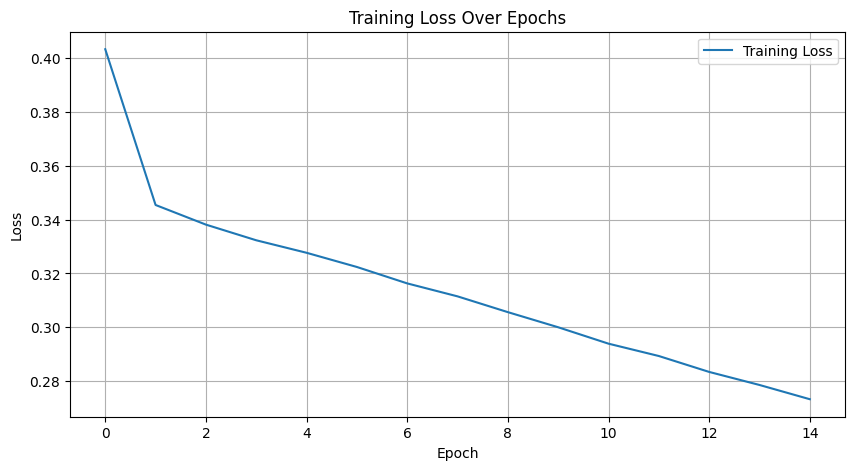

In [ ]:
from tqdm import tqdm

n_epochs = 15

# Your solution here ###########################################################
def train_mlp(mlp, loader_train, optimizer, loss_fn, n_epochs, verbose=False):
    all_losses = []

    for epoch in range(n_epochs):
        epoch_losses = []

        # Wrap the DataLoader with tqdm for visual progress
        if verbose:
            iterable = tqdm(loader_train, desc=f"Epoch {epoch+1}/{n_epochs}")
        else:
            iterable = loader_train

        for x_batch, y_batch in iterable:
            # Move data to the correct device
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            # Perform a training step
            loss = train_nn_step(optimizer, loss_fn, mlp, x_batch, y_batch)
            epoch_losses.append(loss)

            if verbose:
                # Update progress bar with the current batch loss
                iterable.set_postfix({'loss': loss})

        # Record average loss for this epoch
        avg_loss = sum(epoch_losses) / len(epoch_losses)
        all_losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{n_epochs}, Avg Loss: {avg_loss:.4f}")

    return all_losses

all_losses = train_mlp(mlp, loader_train, optimizer, loss_fn, n_epochs)
# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(all_losses, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
plt.show()

**1.3.7 [1pts]** Evaluate the trained model on both the training and test data, using the most relevant metric from those already imported from TorchMetrics.

In [ ]:
# Your solution here ###########################################################

# Alternatives: Accuracy, BinaryF1Score, Precision, Recall
metric_fn = BinaryF1Score(threshold=0.5).to(device)  # Set the threshold for converting logits to binary predictions

metric_tr = eval_nn(mlp, loader_train, metric_fn)
metric_te = eval_nn(mlp, loader_test, metric_fn)

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

print(f"Training metric: {metric_tr:.3f}")
print(f"Test metric:     {metric_te:.3f}")

Training metric: 0.931
Test metric:     0.904


**1.3.8 [3pts]** Try different hyperparameters' combinations, in particular for the hidden dimension of the MLP and the learning rate of the optimizer. Then discuss the obtained results and the learning curves.

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Training with hidden dimension: 4
Epoch 1/15, Avg Loss: 0.5068
Epoch 2/15, Avg Loss: 0.3732
Epoch 3/15, Avg Loss: 0.3534
Epoch 4/15, Avg Loss: 0.3476
Epoch 5/15, Avg Loss: 0.3446
Epoch 6/15, Avg Loss: 0.3429
Epoch 7/15, Avg Loss: 0.3416
Epoch 8/15, Avg Loss: 0.3406
Epoch 9/15, Avg Loss: 0.3400
Epoch 10/15, Avg Loss: 0.3396
Epoch 11/15, Avg Loss: 0.3394
Epoch 12/15, Avg Loss: 0.3387
Epoch 13/15, Avg Loss: 0.3379
Epoch 14/15, Avg Loss: 0.3379
Epoch 15/15, Avg Loss: 0.3376
Train F1 Score: 0.910, Test F1 Score: 0.909
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Training with hidden dimension: 8
Epoch 1/15, Avg Loss: 0.4764
Epoch 2/15, Avg Loss: 0.4049
Epoch 3/15, Avg Loss: 0.389

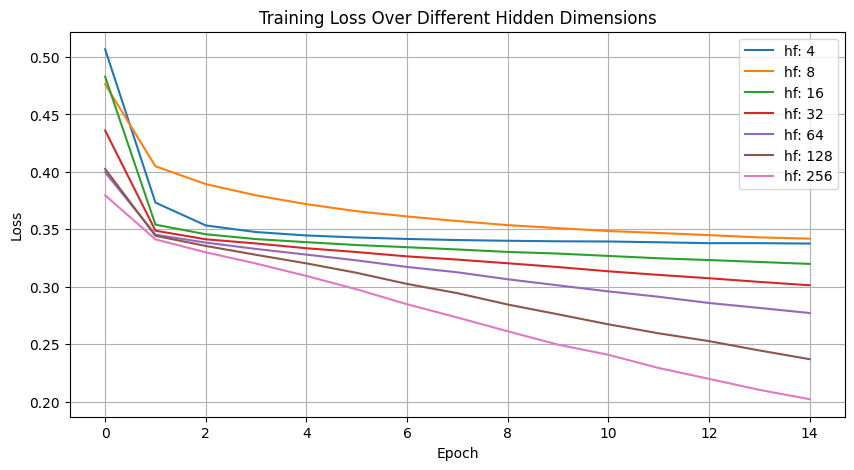

lr: 0.001 


,hidden_dim,eval_tr,eval_te
0,4,0.909858,0.909149
1,8,0.910717,0.907368
2,16,0.916301,0.909574
3,32,0.920412,0.906415
4,64,0.929698,0.906419
5,128,0.943224,0.895522
6,256,0.953003,0.892406


In [ ]:
import pandas as pd

in_features = X_train.shape[1]  # Replace with actual size
hidden_features = [4,8,16,32,64,128,256]  # Example size, can be tuned
learning_rate = 0.001  # Starting learning rate, can be tuned
loss_fn = nn.BCEWithLogitsLoss()
metric_fn = BinaryF1Score(threshold=0.5).to(device)  # Set the threshold for converting logits to binary predictions

model_evaluation = []

# Plotting the losses
plt.figure(figsize=(10, 5))

for hf in hidden_features:
    print("- - - "*30)
    print('Training with hidden dimension:', hf)
    mlp = MLP(in_features=in_features, hidden_features=hf).to(device)
    optimizer = torch.optim.Adam(mlp.parameters(), lr=learning_rate)
    losses = train_mlp(mlp, loader_train, optimizer, loss_fn, n_epochs, verbose=False)
    plt.plot(losses, label=f"hf: {hf}")

    metric_tr = eval_nn(mlp, loader_train, metric_fn)
    metric_te = eval_nn(mlp, loader_test, metric_fn)
    print(f"Train F1 Score: {metric_tr:.3f}, Test F1 Score: {metric_te:.3f}")

    model_evaluation.append({'hidden_dim': hf, 'eval_tr': metric_tr.item(), 'eval_te': metric_te.item()})

plt.title('Training Loss Over Different Hidden Dimensions')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
plt.show()

print('lr:', learning_rate, "")
pd.DataFrame(model_evaluation)

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Training with lr: 0.01
Epoch 1/15, Avg Loss: 0.4077
Epoch 2/15, Avg Loss: 0.3457
Epoch 3/15, Avg Loss: 0.3379
Epoch 4/15, Avg Loss: 0.3324
Epoch 5/15, Avg Loss: 0.3267
Epoch 6/15, Avg Loss: 0.3217
Epoch 7/15, Avg Loss: 0.3162
Epoch 8/15, Avg Loss: 0.3114
Epoch 9/15, Avg Loss: 0.3062
Epoch 10/15, Avg Loss: 0.3005
Epoch 11/15, Avg Loss: 0.2949
Epoch 12/15, Avg Loss: 0.2901
Epoch 13/15, Avg Loss: 0.2847
Epoch 14/15, Avg Loss: 0.2798
Epoch 15/15, Avg Loss: 0.2750
Train F1 Score: 0.931, Test F1 Score: 0.902
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Training with lr: 0.005
Epoch 1/15, Avg Loss: 0.4193
Epoch 2/15, Avg Loss: 0.3462
Epoch 3/15, Avg Loss: 0.3386
Epoch 4/15, Avg Los

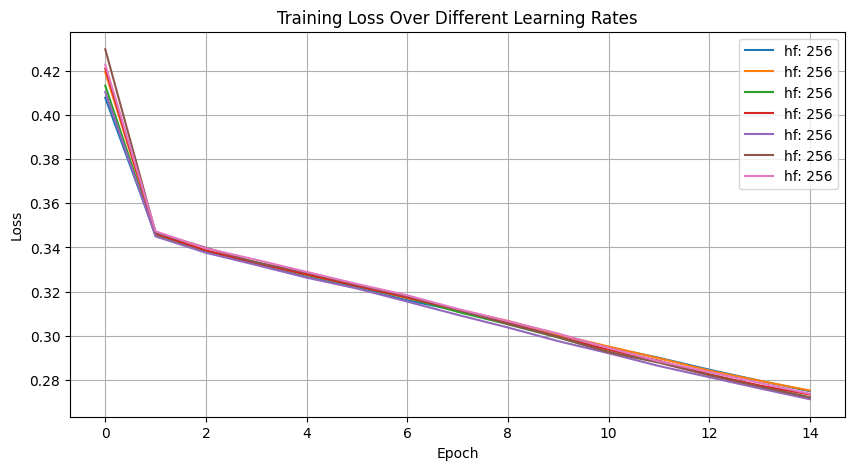

lr: 0.001 


,lr,eval_tr,eval_te
0,0.01000,0.931445,0.902445
1,0.00500,0.929246,0.902960
2,0.00100,0.932025,0.905487
3,0.00050,0.930921,0.906033
4,0.00010,0.931117,0.906462
5,0.00005,0.930495,0.901983
6,0.00001,0.931503,0.903857


In [ ]:
import pandas as pd

in_features = X_train.shape[1]  # Replace with actual size
hidden_dim = 64  # Example size, can be tuned
learning_rates = [1e-2, 5e-3, 1e-3, 5e-4, 1e-4, 5e-5, 1e-5]  # Starting learning rate, can be tuned
loss_fn = nn.BCEWithLogitsLoss()
metric_fn = BinaryF1Score(threshold=0.5).to(device)  # Set the threshold for converting logits to binary predictions

model_evaluation = []

# Plotting the losses
plt.figure(figsize=(10, 5))

for lr in learning_rates:
    print("- - - "*30)
    print('Training with lr:', lr)
    mlp = MLP(in_features=in_features, hidden_features=hidden_dim).to(device)
    optimizer = torch.optim.Adam(mlp.parameters(), lr=learning_rate)
    losses = train_mlp(mlp, loader_train, optimizer, loss_fn, n_epochs, verbose=False)
    plt.plot(losses, label=f"hf: {hf}")

    metric_tr = eval_nn(mlp, loader_train, metric_fn)
    metric_te = eval_nn(mlp, loader_test, metric_fn)
    print(f"Train F1 Score: {metric_tr:.3f}, Test F1 Score: {metric_te:.3f}")

    model_evaluation.append({'lr': lr, 'eval_tr': metric_tr.item(), 'eval_te': metric_te.item()})

plt.title('Training Loss Over Different Learning Rates')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
plt.show()

print('lr:', learning_rate, "")
pd.DataFrame(model_evaluation)

**Your answer here:**
...

### Question 1.4: Graph Neural Networks (20 points)

We will now shift from the standard deep learning paradigm to Graph Neural Networks, to leverage the additional structure of our data.

We already imported [PyTorch Geometric][torch_geometric] as `pyg`, so you can access its submodules as `pyg.nn`, `pyg.data` and so on.

[torch_geometric]: https://pytorch-geometric.readthedocs.io/en/latest/index.html

**1.4.1 [2pts]** Let's start by defining our first GNN. Again, it will be a subclass of the PyTorch `Module`, but this time it will take into account the `edge_index` in its `forward method`. Use two [GCN layers][gcn] to go from input features, here called *channels*, to a hidden dimension defined in the constructor, then to logit readout. Use ReLU activations.

This GNN will map node vectors to node logits, so we can directly read out node probabilities from

[gcn]: https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GCNConv.html

In [ ]:
import torch_geometric as pyg

class GCN(nn.Module):
    # Your solution here #######################################################
    def __init__(self, in_channels: int, hidden_channels: int):
        super(GCN, self).__init__()
        # First GCN layer, input to hidden
        self.conv1 = pyg.nn.GCNConv(in_channels, hidden_channels)
        # Second GCN layer, hidden to output
        self.conv2 = pyg.nn.GCNConv(hidden_channels, 1)  # Assuming output is 1-dimensional logits per node

        # Activation function
        self.relu = nn.ReLU()

    def forward(self, x, edge_index):
        # Apply first GCN layer
        x = self.conv1(x, edge_index)
        # Apply ReLU activation
        x = self.relu(x)
        # Apply second GCN layer
        x = self.conv2(x, edge_index)
        return x

    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

**1.4.2 [3pts]** Perform `n_epochs` of training of a GCN model with 64 hidden channels, using full training data as a batch. Make sure to only use training data in the loss computation by using the `train_mask`. Track the loss value at each step and plot it. Finally, evaluate the model on train and test, using the `metric_fn` from before.

Epoch 1: Loss 0.7279650568962097
Epoch 2: Loss 0.7137547135353088
Epoch 3: Loss 0.7000012993812561
Epoch 4: Loss 0.6867068409919739
Epoch 5: Loss 0.6738687753677368
Epoch 6: Loss 0.6614893078804016
Epoch 7: Loss 0.6495608687400818
Epoch 8: Loss 0.6380778551101685
Epoch 9: Loss 0.6270378828048706
Epoch 10: Loss 0.6164253950119019
Epoch 11: Loss 0.6062235236167908
Epoch 12: Loss 0.5964053869247437
Epoch 13: Loss 0.5869629979133606
Epoch 14: Loss 0.5778838396072388
Epoch 15: Loss 0.5691447854042053


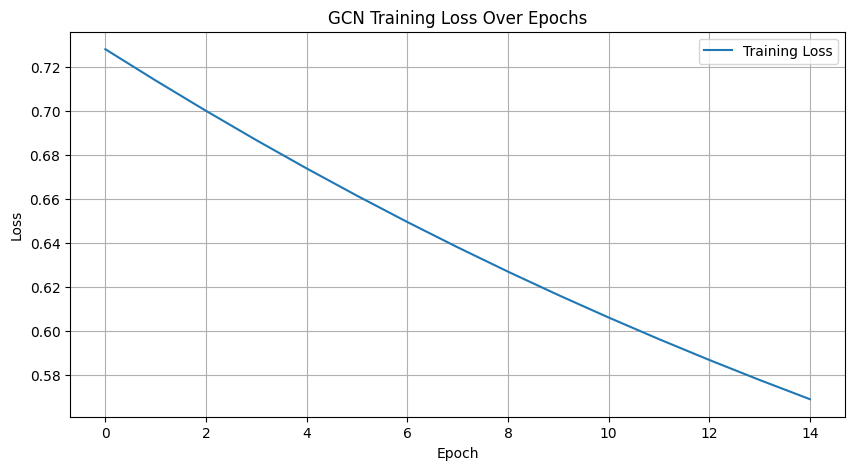

In [ ]:
from tqdm import tqdm

n_epochs = 15
in_features = data.x.shape[1]
hidden_dim = 64
gcn = GCN(in_channels=in_features, hidden_channels=hidden_dim).to(device)

learning_rate = 1e-3
optimizer = torch.optim.Adam(gcn.parameters(), lr=learning_rate)
loss_fn = nn.BCEWithLogitsLoss()

def train_gnn(data, model, optimizer, loss_fn):
  # Ensure data is on the correct device
  x = data.x.to(device)
  edge_index = data.edge_index.to(device)
  y = data.y.float().to(device)  # Convert to float if not already

  epoch_loss = []

  # Your solution here ###########################################################
  for epoch in range(n_epochs):
      model.train()
      optimizer.zero_grad()
      out = model(x, edge_index).squeeze()
      loss = loss_fn(out[train_mask], y[train_mask])
      epoch_loss.append(loss.item())

      loss.backward()
      optimizer.step()

      print(f"Epoch {epoch+1}: Loss {loss.item()}")

  # Plotting the losses
  plt.figure(figsize=(10, 5))
  plt.plot(epoch_loss, label='Training Loss')
  plt.title('GCN Training Loss Over Epochs')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)
  plt.show()
  # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

train_gnn(data, gcn, optimizer, loss_fn)


In [ ]:
def eval_gnn(model: nn.Module, data, mask: torch.Tensor, metric_fn: Metric) -> float:
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        outputs = model(data.x.to(device), data.edge_index.to(device)).squeeze()
        preds = torch.sigmoid(outputs)  # Convert logits to probabilities
        # Apply mask to focus on the relevant nodes
        preds_masked = preds[mask]
        y_masked = data.y[mask].float().to(device)
        metric_fn.update(preds_masked, y_masked)

    final_metric = metric_fn.compute()
    metric_fn.reset()  # Reset the metric for future evaluations
    return final_metric


metric_fn = BinaryF1Score(threshold=0.5).to(device)
metric_tr, metric_te = eval_gnn(gcn, data, train_mask, metric_fn), eval_gnn(gcn, data, ~train_mask, metric_fn),

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

print(f"Training metric: {metric_tr:.3f}")
print(f"Test metric:     {metric_te:.3f}")

Training metric: 0.880
Test metric:     0.886


**1.4.3 [2pts]** Hopefully, we got already some good results, but we would like to test whether stochastic optimization might be better. Batching graph data requires a particular approach, since on top of the design matrix with node features we have to account for edge information. In our setting, we have a single graph with many nodes, and a node level task. A batching strategy consists in sampling nodes with their neighbors, then working with this smaller graphs in a batched way.

Define one [NeighborLoader][neighborloader] for the training data, which will gather neighbors for as many *iterations* as layers in your GCN.

References:
- [Mini batches](https://pytorch-geometric.readthedocs.io/en/latest/get_started/introduction.html#mini-batches)

[neighborloader]: https://pytorch-geometric.readthedocs.io/en/latest/modules/loader.html#torch_geometric.loader.NeighborLoader

In [ ]:
batch_size = 1024

# Your solution here ###########################################################
num_neighbours = 30
num_hops = 2

loader_graph_train = pyg.loader.NeighborLoader(
    data,
    num_neighbors=[num_neighbours] * num_hops,
    batch_size=batch_size,
    input_nodes=train_mask,
    shuffle=True,
    drop_last=False
)

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

**1.4.4 [1pt]** Use the previously defined `train_nn_step` to train a newly initialized GCN with the new loader. Again plot the loss evolution and evaluate the trained model on train and test data.

In [ ]:
# train_nn_step does not take edge_index as an argument...
def train_gnn_step(
    optimizer: optim.Optimizer,
    loss_fn: nn.Module,
    model: nn.Module,
    x: torch.Tensor,
    edge_index: torch.Tensor,
    y: torch.Tensor,
) -> float:
    model.train()  # Used to ensure that relevant blocks are in training mode

    # Your solution here #######################################################

    # Clear previous gradients
    optimizer.zero_grad()

    outputs = model(x, edge_index).squeeze() # Changes shape from [128, 1] to [128]

    loss = loss_fn(outputs, y.float())

    loss.backward()

    optimizer.step()

    return loss.item()

    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Epochs:   7%|▋         | 1/15 [00:02<00:28,  2.02s/it]

Epoch 1: Average Loss 0.5595


Epochs:  13%|█▎        | 2/15 [00:03<00:19,  1.50s/it]

Epoch 2: Average Loss 0.3903


Epochs:  20%|██        | 3/15 [00:04<00:15,  1.28s/it]

Epoch 3: Average Loss 0.3641


Epochs:  27%|██▋       | 4/15 [00:05<00:12,  1.17s/it]

Epoch 4: Average Loss 0.3530


Epochs:  33%|███▎      | 5/15 [00:05<00:10,  1.00s/it]

Epoch 5: Average Loss 0.3459


Epochs:  40%|████      | 6/15 [00:06<00:08,  1.11it/s]

Epoch 6: Average Loss 0.3402


Epochs:  47%|████▋     | 7/15 [00:07<00:06,  1.20it/s]

Epoch 7: Average Loss 0.3368


Epochs:  53%|█████▎    | 8/15 [00:07<00:05,  1.27it/s]

Epoch 8: Average Loss 0.3333


Epochs:  60%|██████    | 9/15 [00:08<00:04,  1.33it/s]

Epoch 9: Average Loss 0.3304


Epochs:  67%|██████▋   | 10/15 [00:09<00:03,  1.37it/s]

Epoch 10: Average Loss 0.3266


Epochs:  73%|███████▎  | 11/15 [00:10<00:02,  1.40it/s]

Epoch 11: Average Loss 0.3239


Epochs:  80%|████████  | 12/15 [00:10<00:02,  1.42it/s]

Epoch 12: Average Loss 0.3223


Epochs:  87%|████████▋ | 13/15 [00:11<00:01,  1.44it/s]

Epoch 13: Average Loss 0.3196


Epochs:  93%|█████████▎| 14/15 [00:12<00:00,  1.39it/s]

Epoch 14: Average Loss 0.3170


Epochs: 100%|██████████| 15/15 [00:13<00:00,  1.15it/s]

Epoch 15: Average Loss 0.3155


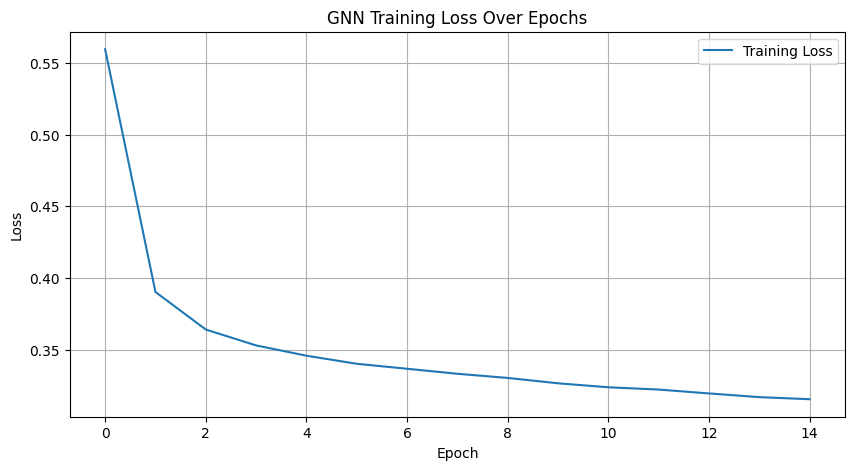

In [ ]:
from tqdm import tqdm

n_epochs = 15
in_features = data.x.shape[1]
hidden_dim = 64
gcn = GCN(in_channels=in_features, hidden_channels=hidden_dim).to(device)

learning_rate = 1e-3
optimizer = torch.optim.Adam(gcn.parameters(), lr=learning_rate)
loss_fn = nn.BCEWithLogitsLoss()


def train_gnn_batched(data, model, optimizer, loss_fn):
  all_losses = []

  # Your solution here ###########################################################
  for epoch in tqdm(range(n_epochs), desc='Epochs'):
      batch_losses = []
      for batch_data in data:
          batch_data = batch_data.to(device)

          loss = train_gnn_step(
              optimizer,
              loss_fn,
              model,
              batch_data.x,
              batch_data.edge_index,
              batch_data.y  # Ensure that y is masked appropriately
          )
          batch_losses.append(loss)
      epoch_loss = sum(batch_losses) / len(batch_losses)
      all_losses.append(epoch_loss)
      print(f"Epoch {epoch+1}: Average Loss {epoch_loss:.4f}")

  # Plotting the losses
  plt.figure(figsize=(10, 5))
  plt.plot(all_losses, label='Training Loss')
  plt.title('GNN Training Loss Over Epochs')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)
  # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  plt.show()

train_gnn_batched(loader_graph_train, gcn, optimizer, loss_fn)


**1.4.5 [1pts]** Predict the label probabilities of each node and evaluate.

In [ ]:
# Your solution here ###########################################################

metric_tr, metric_te = eval_gnn(gcn, data, train_mask, metric_fn), eval_gnn(gcn, data, ~train_mask, metric_fn)

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

print(f"Training metric: {metric_tr:.3f}")
print(f"Test metric:     {metric_te:.3f}")

Training metric: 0.910
Test metric:     0.916


**1.4.6 [2pts]** Define a new GNN architecture using [graph attention layers][gat].

[gat]: https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GATv2Conv.html#torch_geometric.nn.conv.GATv2Conv

In [ ]:
class GAT(nn.Module):
    # Your solution here #######################################################
    def __init__(self, in_channels: int, hidden_channels: int):
        super(GAT, self).__init__()
        # First GAT layer, transforming input features to hidden dimensions
        self.conv1 = pyg.nn.GATv2Conv(in_channels, hidden_channels, heads=8, dropout=0.6)
        # Second GAT layer, from hidden dimensions to output features
        # Using multiple heads and concatenating them typically helps learning
        self.conv2 = pyg.nn.GATv2Conv(hidden_channels * 8, 1, heads=1, concat=False, dropout=0.6)
        self.relu = nn.ReLU()

    def forward(self, x, edge_index):
        # Input features are transformed by the first GAT layer
        x = self.relu(self.conv1(x, edge_index))
        # Output from the first layer passed through second GAT layer
        x = self.conv2(x, edge_index)
        return x

    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

**1.4.7 [3pts]** Train and evaluate the GAT model with both methods.

FULL TRAINING
Epoch 1: Loss 0.691431999206543
Epoch 2: Loss 0.6261398792266846
Epoch 3: Loss 0.5814621448516846
Epoch 4: Loss 0.5487048625946045
Epoch 5: Loss 0.5263000130653381
Epoch 6: Loss 0.5093005299568176
Epoch 7: Loss 0.4957556426525116
Epoch 8: Loss 0.4821348190307617
Epoch 9: Loss 0.47281548380851746
Epoch 10: Loss 0.4698854982852936
Epoch 11: Loss 0.4677165150642395
Epoch 12: Loss 0.46717536449432373
Epoch 13: Loss 0.4665246307849884
Epoch 14: Loss 0.46261894702911377
Epoch 15: Loss 0.4670575261116028


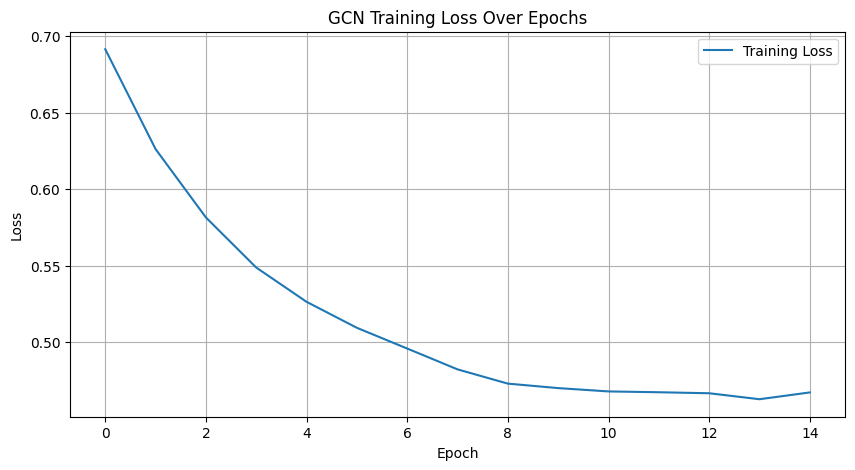

Training metric: 0.898
Test metric:     0.901
BATCH TRAINING


Epochs:   7%|▋         | 1/15 [00:02<00:33,  2.38s/it]

Epoch 1: Average Loss 0.5903


Epochs:  13%|█▎        | 2/15 [00:04<00:30,  2.34s/it]

Epoch 2: Average Loss 0.5159


Epochs:  20%|██        | 3/15 [00:06<00:27,  2.32s/it]

Epoch 3: Average Loss 0.4988


Epochs:  27%|██▋       | 4/15 [00:09<00:25,  2.31s/it]

Epoch 4: Average Loss 0.4874


Epochs:  33%|███▎      | 5/15 [00:11<00:23,  2.31s/it]

Epoch 5: Average Loss 0.4777


Epochs:  40%|████      | 6/15 [00:14<00:21,  2.37s/it]

Epoch 6: Average Loss 0.4711


Epochs:  47%|████▋     | 7/15 [00:16<00:18,  2.35s/it]

Epoch 7: Average Loss 0.4644


Epochs:  53%|█████▎    | 8/15 [00:18<00:16,  2.33s/it]

Epoch 8: Average Loss 0.4585


Epochs:  60%|██████    | 9/15 [00:20<00:13,  2.31s/it]

Epoch 9: Average Loss 0.4536


Epochs:  67%|██████▋   | 10/15 [00:23<00:11,  2.30s/it]

Epoch 10: Average Loss 0.4482


Epochs:  73%|███████▎  | 11/15 [00:25<00:09,  2.33s/it]

Epoch 11: Average Loss 0.4437


Epochs:  80%|████████  | 12/15 [00:28<00:07,  2.36s/it]

Epoch 12: Average Loss 0.4392


Epochs:  87%|████████▋ | 13/15 [00:30<00:04,  2.34s/it]

Epoch 13: Average Loss 0.4349


Epochs:  93%|█████████▎| 14/15 [00:32<00:02,  2.33s/it]

Epoch 14: Average Loss 0.4302


Epochs: 100%|██████████| 15/15 [00:34<00:00,  2.33s/it]

Epoch 15: Average Loss 0.4265


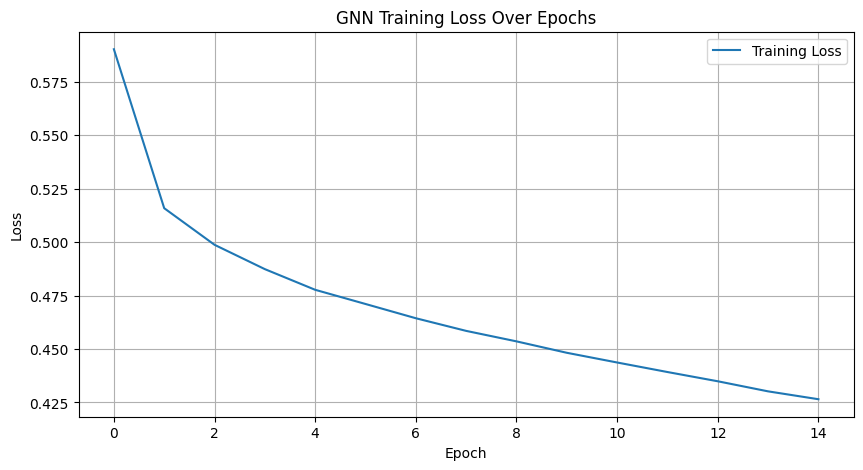

Training metric: 0.919
Test metric:     0.920


In [ ]:
print("FULL TRAINING")

# Your solution here ###########################################################

n_epochs = 15
in_features = data.x.shape[1]
hidden_dim = 64
gat = GAT(in_channels=in_features, hidden_channels=hidden_dim).to(device)

learning_rate = 1e-3
optimizer = torch.optim.Adam(gat.parameters(), lr=learning_rate)
loss_fn = nn.BCEWithLogitsLoss()

train_gnn(data, gat, optimizer, loss_fn)

metric_tr, metric_te = eval_gnn(gat, data, train_mask, metric_fn), eval_gnn(gat, data, ~train_mask, metric_fn)

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
#plt.title("Full training")
#plt.show()

print(f"Training metric: {metric_tr:.3f}")
print(f"Test metric:     {metric_te:.3f}")

print("BATCH TRAINING")

# Your solution here ###########################################################

gat = GAT(in_channels=in_features, hidden_channels=hidden_dim).to(device)
optimizer = torch.optim.Adam(gat.parameters(), lr=learning_rate)
loss_fn = nn.BCEWithLogitsLoss()

train_gnn_batched(loader_graph_train, gat, optimizer, loss_fn)

metric_tr, metric_te = eval_gnn(gat, data, train_mask, metric_fn), eval_gnn(gat, data, ~train_mask, metric_fn)

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

#plt.title("Full training")
#plt.show()

print(f"Training metric: {metric_tr:.3f}")
print(f"Test metric:     {metric_te:.3f}")

**1.4.8 [6pts]** Compare the results of these two architectures, with multiple hyperparameters, and the previous results. Discuss the eventual differences in performance highlighting the properties that you believe influence most the outcome.

**Your answer here:**
...

## Part 2: Learning graphs [20 points]

Graph attention layers are quite interesting, since they use the local and the incoming information of a node to give different weights to each neighbor. This is conceptually similar to learning a new graph on top of the existing one.

In this part, we design a block that, from node embeddings, will produce a new graph. The idea is similar to the one in the paper "Discrete Graph Structure Learning for Forecasting Multiple Time Series", which is illustrated in the following Figure.

References:
- C. Shang, J. Chen, and J. Bi, “Discrete Graph Structure Learning for Forecasting Multiple Time Series,” presented at the International Conference on Learning Representations, Feb. 2022. Accessed: Aug. 15, 2022. Available: https://openreview.net/forum?id=WEHSlH5mOk




![Graph Learning Module](graph_learning_module.png)

As we can see from the schema, we have three main components:
1. **Feature extractor**: mapping each node to a new, synthesized representation;
2. **Link predictor**: for each pair of node representations, predict the probability that an edge links them. We gather probabilities in a *structure matrix* $\theta$;
3. **Sampling**: Sample one, or multiple, discrete graphs from the structure matrix.

In the following questions, we will break down these components.

### Question 2.1: Sampling (4 points)

Sampling is the most intriguing part of our module, as it maps, randomly, continuous probabilities to discrete edges.
Ideally, we would like to sample each edge with a probability $\theta$, following a Bernoulli distribution, but this would be hard to backpropagate through.

What we do instead is known as the **Gumbel Trick**.
We sample edges using a [Gumbel][gumbel] reparameterization, which allows differentiating for $\theta$ through it. With $g_{ij}^1, g_{ij}^2 \sim \operatorname{Gumbel}(0,1)$ for all $i,j$, and $s$ a temperature parameter,
$$
A_{ij} = \operatorname{sigmoid}\left(
  \frac{
    \log\left( \frac{\theta_{ij}}{1 - \theta_{ij}} \right)
    + g_{ij}^1 - g_{ij}^2
  }{s}
\right)
.
$$
By letting the temperature go to zero, we can get closer and closer to a Bernoulli distribution.

[gumbel]: https://en.wikipedia.org/wiki/Gumbel_distribution


**2.1.1 [2pts]** Define a function to sample a matrix of Gumbel variables of given shape, knowing that, for $p$ sampled uniformly in (0,1), then $Q(p) \sim \operatorname{Gumbel}(\mu,\beta)$
$$
  Q(p)=\mu-\beta \ln (-\ln (p))
  .
$$

In [2]:
import torch

def sample_gumbel(shape, mu=0, beta=1):
    # Your solution here #######################################################
    
    # Sample uniform variables in (0, 1)
    uniform_samples = torch.rand(shape)
    # Apply the Gumbel inverse CDF transformation
    gumbel_samples = mu - beta * torch.log(-torch.log(uniform_samples))
    return gumbel_samples

    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

print("Testing sample_gumbel")
print(sample_gumbel((2, 3), 0, 1))

Testing sample_gumbel
tensor([[ 1.4038,  2.3292,  0.4392],
        [ 0.0377,  1.9642, -0.2927]])


**2.1.2 [2pts]** Note that $log(\frac{\theta}{1 - \theta})$ is the sigmoid function, so we can work with unnormalized edge logits instead of probabilities. Define a function to sample an adjacency matrix $A$ from edge logits using the Gumbel Trick.

In [3]:
def sample_gumbel_trick(logits, temperature, mu=0, beta=1):
    # Your solution here #######################################################
    
    # Draw two Gumbel variables
    g1 = sample_gumbel(logits.shape, mu, beta)
    g2 = sample_gumbel(logits.shape, mu, beta)
    print(g1, g2)
    # Apply the Gumbel trick to sample adjacency matrix
    return torch.sigmoid((logits + g1 - g2) / temperature)
    
    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


print("Testing sample_gumbel_trick")
print(sample_gumbel_trick(torch.tensor([1000, 0, 0, -10]), temperature=10))
print(sample_gumbel_trick(torch.tensor([1000, 0, 0, -10]), temperature=1))
print(sample_gumbel_trick(torch.tensor([1000, 0, 0, -10]), temperature=1e-2))

Testing sample_gumbel_trick
tensor([ 0.1139, -0.6930,  0.6422,  0.0792]) tensor([2.2809, 1.2740, 2.4245, 0.1693])
tensor([1.0000, 0.4510, 0.4556, 0.2672])
tensor([0.6554, 1.1249, 4.2942, 0.8282]) tensor([-0.0184, -0.0277,  0.2831, -0.9520])
tensor([1.0000e+00, 7.5999e-01, 9.8221e-01, 2.6920e-04])
tensor([-0.3227,  0.8190,  0.7572, -0.0289]) tensor([-0.8060, -0.6304, -0.5121, -0.2986])
tensor([1., 1., 1., 0.])


### Question 2.2: Link predictor (11 points)

GNNs are all about node embeddings, which by now we should know how to deal with. The missing component is therefore the **link predictor**.

Naively, we could iterate through all pairs of nodes and apply a predictor layer, but it would be highly inefficient.
To leverage tensor manipulation, let's start by gathering paired node representations in a matrix, so that we can predict probabilities in parallel.

**2.2.1 [3pts]**  Define a function that takes as input a tensor of node embeddings, and returns a tensor that concatenate embeddings pairwise. Use [triu_indices][triu_indices] to have pairs appearing only once and avoid self loops, and return the indices along with the embeddings.

[triu_indices]: https://pytorch.org/docs/stable/generated/torch.triu_indices.html

In [6]:
# COMMENT: alternative implementation -> use a .unsqueeze-operation to get 2D to 3D tensor

def pair_embeddings(x) -> (torch.Tensor, torch.Tensor):
    # This implementation only handles 2D and 3D input tensors (x)
    assert x.dim() in [2,3]
    
    # Determine if we have batched embeddings or not
    if x.dim() == 3: # -----> Batch mode
        batch_size, num_nodes, _ = x.shape
        # Get the indices of the upper triangular part of the matrix for one example 
        row_indices, col_indices = torch.triu_indices(num_nodes, num_nodes, 1)
        
        # Prepare for batch operation: use broadcasting to get pairs for all batches.
        row_indices, col_indices = row_indices.repeat(batch_size, 1), col_indices.repeat(batch_size, 1)
        
        # Adjust indices for batched data
        batch_indices = torch.arange(batch_size).repeat_interleave(row_indices.shape[1])
        row_indices, col_indices = row_indices.flatten(), col_indices.flatten()
        
        # Gather pairs of embeddings based on the indices and concatenate them
        paired_embeddings = torch.cat((x[batch_indices, row_indices], x[batch_indices, col_indices]), dim=1)
    else: # -----> Non-batch mode
        num_nodes = x.size(0)
        row_indices, col_indices = torch.triu_indices(num_nodes, num_nodes, 1)
        paired_embeddings = torch.cat((x[row_indices], x[col_indices]), dim=1)
        batch_indices = None  # No batch indices in non-batch mode

    return paired_embeddings, (row_indices, col_indices, batch_indices)

print("Testing pair_embeddings")
print(pair_embeddings(torch.tensor([[1.0], [2.0], [3.0]]))[0])
print(pair_embeddings(torch.tensor([[[1.0], [2.0], [3.0]], [[4.0], [5.0], [6.0]]]))[0])

Testing pair_embeddings
tensor([[1., 2.],
        [1., 3.],
        [2., 3.]])
tensor([[1., 2.],
        [1., 3.],
        [2., 3.],
        [4., 5.],
        [4., 6.],
        [5., 6.]])


**2.2.2 [8pts]** Define a PyTorch module that takes as input node embeddings, compute link probabilities with a two-layer perceptron on paired embeddings, then samples edges with the Gumbel trick. The output of the forward method will be a PyTorch Geometric [EdgeIndex][edge_index] of tensors representing indices and weights corresponding to positively sampled edges. You might need a `eps` threshold to avoid numerical errors.

[edge_index]: https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.edge_index.EdgeIndex

In [ ]:
# COMMENT: ideally we would use the gumbal trick function we implemented earlier. Modifications should be made

class MLPGraphLearn(nn.Module):
    # Your solution here ###########################################################
    def __init__(
        self, in_features: int, hidden_features: int, temperature: float, eps=1e-10
    ):
        super(MLPGraphLearn, self).__init__()
        self.eps = eps
        self.temperature = temperature
        # Two-layer perceptron
        self.fc1 = nn.Linear(in_features*2, hidden_features)
        self.fc2 = nn.Linear(hidden_features, 1)  # Outputs probability for each pair
    
    def forward(self, x):
        # Compute all pairwise embeddings
        paired_embeddings, (row_indices, col_indices, batch_indices) = pair_embeddings(x)
        # Feed through MLP
        out = torch.nn.functional.relu(self.fc1(paired_embeddings))
        logits = self.fc2(out).squeeze(-1)
        
        # Gumbel trick to sample edges
        gumbel_noise = -torch.log(-torch.log(torch.rand_like(logits) + self.eps) + self.eps)
        logits = (logits + gumbel_noise) / self.temperature
        sampled_edges = torch.nn.functional.sigmoid(logits) > 0.5
        
        # Construct the edge index tensor
        edge_indices = torch.stack([row_indices[sampled_edges], col_indices[sampled_edges]], dim=0)
        
        return edge_indices

    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


print("Testing MLPGraphLearn")
mlp_gl = MLPGraphLearn(2, 5, 0.01)
mlp_gl(torch.tensor([[[1.0, 2.0], [0.5, 7.1], [-0.1, 0.3]]]))

### Question 2.3: Classifiers with Graph Learning Module (5 points)

Let's introduce our graph learning block into some classifiers.


**2.3.1 [4pts]** Define a classifier that first produces node embeddings with a Linear layer with ReLU activation, which it feeds to the previously defined GL module; then it performs two graph convolutions on the original node features using the learned graph.

In [ ]:
class MLPGLClassifier(nn.Module):
    # Your solution here #######################################################
    def __init__(
        self,
        in_features: int,
        gl_node_features_in: int = 64,
        gl_node_features_hidden: int = 32,
        gcn_hidden: int = 64,
    ): ...

    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

**2.3.2 [1pt]** Unfortunately, training and evaluating the `MLPGLClassifier` might take too long. Let's just test whether it works: instantiate the classifier and compute the graph embedding.

In [ ]:
# Your solution here ###########################################################

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

## Part 3 (Theory): Forcing causal structure in learned graphs [35 points]

Understanding and mapping the causal relationships among data variables, represented by directed acyclic graphs (DAGs), presents a significant challenge. The search space for these DAGs is combinatorial, and it scales super exponentially with the number of nodes, further complicating the task.

Assuming causal relationships between data variables, the basic DAG learning problem is formulated as follows: Let $\mathbf{X} \in \mathbb{R}^{n \times d}$ be a data matrix consisting of $n$ i.i.d. observations of the random vector $x=\left(x_1, \ldots, x_d\right)$ and let $\mathbb{D}$ denote the (discrete) space of DAGs $\mathrm{G}=(\mathrm{V}, \mathrm{E})$ on $d$ nodes. Given $\mathbf{X}$, we seek to learn a DAG $\mathrm{G}$ represented by its adjacency matrix $A$ such that:

$$
\begin{array}{rl}
\min _{A \in \mathbb{R}^{d \times d}} &  F(A):= \frac{1}{2 n}\|\mathbf{X}-GNN(\mathbf{X}, A)\|_F^2+\lambda\|A\|_1 \\
\text { subject to } &  A \in \mathbb{D} ,
\end{array}
$$
where $\mathbb{D}$ represents a DAG space and GNN is a graph neural network that simultaneously learns a DAG $A$ and accurately predicts an estimation of the matrix $\mathbf{X}$. The minimization of the aforementioned problem guides us towards finding the causal graph that generates the data $\mathbf{X}$. Although $F(A)$ is continuous, the DAG constraint $A \in \mathbb{D}$ remains a challenge to enforce.

The objective is to make the aforementioned problem amenable to black-box optimization (in order to use SGD, ADAM...). We aim to replace the combinatorial acyclicity constraint $A \in \mathbb{D}$ with a single smooth equality constraint $h(A) = 0$. Thus, the objective of this section is to find a smooth function $h: \mathbb{R}^{d \times d} \rightarrow \mathbb{R}$ that will satisfy the following: $h(A)=0$ if and only if $A$ is acyclic (i.e. $A \in \mathbb{D}$). Furthermore, we want to ensure that $h$ and its derivatives are easy to compute.

### Question 3.1: DAGness property for binary matrix with spectral radius condition (8 points)

In this question we want to find out when a matrix $A \in\{0,1\}^{d \times d}$ corresponds to an acyclic graph.

Suppose $A \in\{0,1\}^{d \times d}$ and $r(A)<1$, $r(A)$ is the spectral radius of the matrix $A$, and it corresponds to the largest absolute eigenvalue of $A$.



**3.1.1 [2pts]** Justify the convergence of $\sum_{k=0}^{\infty} A^k$ and show that:
$$\left(I_n-A\right)^{-1}=\sum_{k=0}^{\infty} A^k$$

**Your answer here:**
...

**3.1.2 [6pts]** Show that $A$ is a $D A G$ if and only if $\operatorname{tr}(I-A)^{-1}=d$

**Your answer here:**
...

Having an assumption on $r(A) < 1$ limits the application of our results. For this reason, our objective is to generalize the previous result to binary matrices.


### Question 3.2: DAGness property for binary matrix (8 points)

Suppose $A \in\{0,1\}^{d \times d}$.

**3.2.1 [4pts]**  Prove the existence of the exponential matrix, we recall that $e^{A} = \sum_{k=0}^{\infty} \frac{A^k}{k !}$


**Your answer here:**
...

**3.2.2 [4pts]** Show that $A$ is a $D A G$ if and only if $\operatorname{tr} e^A=d$, where $e^A$ is the exponential matrix.

**Your answer here:**
...

**3.3 [5pts]** DAGness property for weighted adjacency matrices

Suppose $A \in \mathbb{R}^{d \times d}$. Knowing that the equivalence of Question 3.2 is correct for any nonnegative weighted matrix $A$, propose a function $f$ such that $A$ is a $D A G$ if and only if $\operatorname{tr} e^{f(A)}=d$.


**Your answer here:**
...

**3.4 [7pts]** Compute the gradient of $h(A) = \operatorname{tr} e^{f(A)}-d$.

**Your answer here:**
...

**3.5 [7pts]** Other alternatives

Suppose $A \in \mathbb{R}^{d \times d}$. For the previously proposed function $f$ show that for any $\alpha > 0 $, $A$ is a $D A G$ if and only if $\operatorname{tr}\left[(I+\alpha f(A))^d\right]-d=0$.

**Your answer here:**
...